In [6]:
#Загрузка библиотек
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## ЗАДАЧА
У вас есть сеты с данными по ежедневным прдажам. Ваша задача - **спрогнозировать объем проданных товаров на ближайшие пару месяцев**. 
Для этого в первую очередь вам нужно произвести действи ядля очистки и подготовки данных (Feature Engeniring) - в этом блоку будут небольшие подсказки. Необходимо использовать три разных варианта моделей для прогноза. Не забудьте проверить модель на адекватность.

**Описание полей**:

- ID - идентификатор строки
- shop_id - уникальный идентификатор магазина
- item_id - уникальный идентификатор продукта
- item_category_id - уникальный идентификатор категории товара
- date_block_num - последовательный номер месяца (для удобства). Например, January 2013 - 0, February 2013 - 1,..., October 2015 - 33
- date - дата в формате dd/mm/yyyy
- item_cnt_day - количество вроданного товара.
- item_price - цена единцы товара
- item_name - Название товара
- shop_name - Название магазина
- item_category_name - Название категории товара

### 1. Загружаем данные

In [8]:
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
sales = pd.read_csv('sales_train.csv')

In [9]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,1709.05,1.00
4,15.01.2013,0,25,2555,1099.00,1.00
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.00
2935845,09.10.2015,33,25,7460,299.00,1.00
2935846,14.10.2015,33,25,7459,349.00,1.00
2935847,22.10.2015,33,25,7440,299.00,1.00


### 2. Объединяем датасеты

In [10]:
item_categ = items.merge(categories, on="item_category_id", how="left")
pokupki = sales.merge(item_categ, on="item_id", how="left")
pokupki = pokupki.merge(shops, on="shop_id", how="left")
pokupki

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.00,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.00,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935845,09.10.2015,33,25,7460,299.00,1.00,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935846,14.10.2015,33,25,7459,349.00,1.00,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935847,22.10.2015,33,25,7440,299.00,1.00,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


### 3. Выведем количество строк и столбцов в полученном сете

In [5]:
pokupki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    int64  
 8   item_category_name  object 
 9   shop_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


### 4. Транспонируем фрейм и выведем первые 5 столбцов

In [6]:
pokupki.T.iloc[:, :5]

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1.00,1.00,-1.00,1.00,1.00
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""


### 5.Используем соответствующую функцию, чтобы вывести полное описание столбцов в соответствии со статистическими показателями


In [7]:
pokupki.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


### 6. За какой период представлены данные в датасете?

In [12]:
pokupki["date"]= pd.to_datetime(pokupki["date"], format='%d.%m.%Y')
print("Данные предоставлены с", str(pokupki["date"].min())[:10], "по", str(pokupki["date"].max())[:10])


Данные предоставлены с 2013-01-01 по 2015-10-31


### 7. Начинаем очистку данных
Выведем только те строки, в которых цена не равна 0

In [9]:
df_big[df_big["item_price"] != 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.00,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.00,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935845,2015-10-09,33,25,7460,299.00,1.00,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935846,2015-10-14,33,25,7459,349.00,1.00,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935847,2015-10-22,33,25,7440,299.00,1.00,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


### 8. Чтобы избежать утечки данных, оставим только те столбцы, которые содержат только id 

In [10]:
df_big.loc[:, ["shop_id", "item_id", "item_category_id"]]

,shop_id,item_id,item_category_id
0,59,22154,37
1,25,2552,58
2,25,2552,58
3,25,2554,58
4,25,2555,56
...,...,...,...
2935844,25,7409,55
2935845,25,7460,55
2935846,25,7459,55
2935847,25,7440,57


### 9. Сгруппируем данные по номерам месяцев

In [11]:
df_big["month"] = df_big["date"].dt.to_period("M")
df_big["revenue"] = (df_big.item_price*df_big.item_cnt_day)/1000000
t = df_big.groupby(df_big["month"])["revenue"].sum()
t

month
2013-01    91.95
2013-02    90.67
2013-03   104.93
2013-04    69.15
2013-05    65.07
2013-06    79.55
2013-07    69.35
2013-08    74.30
2013-09   119.08
2013-10   107.24
2013-11   138.67
2013-12   207.57
2014-01    98.23
2014-02   107.43
2014-03   109.12
2014-04    80.65
2014-05    91.28
2014-06    82.67
2014-07    76.49
2014-08    89.60
2014-09   114.72
2014-10   112.53
2014-11   152.04
2014-12   232.03
2015-01   118.93
2015-02    86.59
2015-03    86.48
2015-04    90.25
2015-05    88.58
2015-06    65.40
2015-07    59.41
2015-08    61.75
2015-09    92.91
2015-10    84.34
Freq: M, Name: revenue, dtype: float64

### 10. Добавим столбцы  с месяцем и годом для последующей возможной агрегации

In [12]:
df_big["year"] = df_big["date"].dt.to_period("Y")
df_big

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,revenue,year
0,2013-01-02,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013-01,0.00,2013
1,2013-01-03,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01,0.00,2013
2,2013-01-05,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01,-0.00,2013
3,2013-01-06,0,25,2554,1709.05,1.00,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01,0.00,2013
4,2013-01-15,0,25,2555,1099.00,1.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",2013-01,0.00,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.00,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",2015-10,0.00,2015
2935845,2015-10-09,33,25,7460,299.00,1.00,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",2015-10,0.00,2015
2935846,2015-10-14,33,25,7459,349.00,1.00,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",2015-10,0.00,2015
2935847,2015-10-22,33,25,7440,299.00,1.00,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум""",2015-10,0.00,2015


### 11. Исследуем данные

**11.1 EDA(Exploratory Data Analysis)**

In [13]:
df_big.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
month                 0
revenue               0
year                  0
dtype: int64

In [14]:
df_big['item_category_name'].value_counts()

Кино - DVD                             564652
Игры PC - Стандартные издания          351591
Музыка - CD локального производства    339585
Игры - PS3                             208219
Кино - Blu-Ray                         192674
                                        ...  
Книги - Путеводители                        3
Аксессуары - PS2                            2
Книги - Открытки                            2
Книги - Познавательная литература           1
Игровые консоли - PS2                       1
Name: item_category_name, Length: 84, dtype: int64

In [15]:
df_big['shop_name'].value_counts()

Москва ТЦ "Семеновский"                            235636
Москва ТРК "Атриум"                                186104
Химки ТЦ "Мега"                                    143480
Москва ТЦ "МЕГА Теплый Стан" II                    142234
Якутск Орджоникидзе, 56                            117428
СПб ТК "Невский Центр"                             109253
Москва ТЦ "МЕГА Белая Дача II"                     105366
Воронеж (Плехановская, 13)                          82663
Якутск ТЦ "Центральный"                             71441
Чехов ТРЦ "Карнавал"                                69573
Сергиев Посад ТЦ "7Я"                               66321
Тюмень ТЦ "Гудвин"                                  65173
Курск ТЦ "Пушкинский"                               63911
Калуга ТРЦ "XXI век"                                59511
Н.Новгород ТРЦ "Фантастика"                         58445
Москва МТРЦ "Афи Молл"                              58133
Воронеж ТРЦ "Максимир"                              58076
Сургут ТРЦ "Си

In [16]:
df_big.groupby(['item_category_name', 'item_name']).count()['item_id']

item_category_name       item_name                                                      
PC - Гарнитуры/Наушники  Наушники PHILIPS SBC HC8680                                        1
                         Наушники RITMIX RH-120                                             1
                         Наушники RITMIX RH-124 Black                                       1
Аксессуары - PS2         PS2: Карта памяти 8 Мб черная (Memory Card 8Mb - 102304: SCEE)     1
                         Pelican. Геймпад Nerf Wireless Controller PS2 (assorted colors)    1
                                                                                           ..
Элементы питания         Элемент питания GP 15AU (LR6) - Блистер 2 шт Ultra                 1
                         Элемент питания GP 24A (LR03) - Блистер 2 шт                       2
                         Элемент питания GP 24AU (LR03) - Блистер 2 шт Ultra                3
                         Элемент питания КОСМОС LR03 2*BL        

In [17]:
df_big.groupby('item_category_name').count()['item_id'].sort_values(ascending=False)

item_category_name
Кино - DVD                             564652
Игры PC - Стандартные издания          351591
Музыка - CD локального производства    339585
Игры - PS3                             208219
Кино - Blu-Ray                         192674
                                        ...  
PC - Гарнитуры/Наушники                     3
Аксессуары - PS2                            2
Книги - Открытки                            2
Игровые консоли - PS2                       1
Книги - Познавательная литература           1
Name: item_id, Length: 84, dtype: int64

In [18]:
df_big.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,revenue,year
0,2013-01-02,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013-01,0.00,2013
1,2013-01-03,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01,0.00,2013
2,2013-01-05,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01,-0.00,2013
3,2013-01-06,0,25,2554,1709.05,1.00,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",2013-01,0.00,2013
4,2013-01-15,0,25,2555,1099.00,1.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",2013-01,0.00,2013


In [19]:
df_big.groupby('item_category_name').sum()['revenue'].sort_values(ascending=False)

item_category_name
Игры - PS3                          412.05
Игры - PS4                          373.01
Игровые консоли - PS4               292.24
Игры - XBOX 360                     259.62
Игры PC - Стандартные издания       257.52
                                     ...  
Аксессуары - PS2                      0.00
Книги - Путеводители                  0.00
PC - Гарнитуры/Наушники               0.00
Книги - Познавательная литература     0.00
Книги - Открытки                      0.00
Name: revenue, Length: 84, dtype: float64

In [20]:
t = df_big.loc[:, ['item_price', 'revenue']]
t.describe()

,item_price,revenue
count,2935849.00,2935849.00
mean,890.85,0.00
std,1729.80,0.01
min,-1.00,-0.07
25%,249.00,0.00
50%,399.00,0.00
75%,999.00,0.00
max,307980.00,1.83


In [21]:
df_big.groupby(df_big.shop_name)["revenue"].sum().reset_index().sort_values(by='revenue', ascending=False)

,shop_name,revenue
31,"Москва ТЦ ""Семеновский""",235.22
25,"Москва ТРК ""Атриум""",216.48
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",159.75
42,"СПб ТК ""Невский Центр""",151.92
54,"Химки ТЦ ""Мега""",141.94
27,"Москва ТЦ ""МЕГА Белая Дача II""",140.63
57,"Якутск Орджоникидзе, 56",113.00
12,Интернет-магазин ЧС,112.21
6,"Воронеж (Плехановская, 13)",98.07
18,"Красноярск ТЦ ""Июнь""",83.39


In [22]:
#Заметим, что в названии двух торговых центров допущена ошибка. Поэтому заменим неверные названия на правильные:
df_big["shop_name"][df_big["shop_name"] == '!Якутск Орджоникидзе, 56 фран'] = 'Якутск Орджоникидзе, 56'
df_big["shop_name"][df_big["shop_name"] == '!Якутск ТЦ "Центральный" фран'] = 'Якутск ТЦ "Центральный"'
df_big["shop_name"][df_big["shop_name"] == '!Якутск ТЦ "Центральный" фран'] = 'Якутск ТЦ "Центральный"'
df_big["shop_name"][df_big["shop_name"] == 'Жуковский ул. Чкалова 39м?'] = 'Жуковский ул. Чкалова 39'
df_big["shop_name"][df_big["shop_name"] == 'Жуковский ул. Чкалова 39м²'] = 'Жуковский ул. Чкалова 39'

In [23]:
print("В данном датасете представлено", df_big["shop_name"].nunique(), "магазинов")
print("В данном датасете представлено", df_big["item_category_id"].nunique(), "категории товаров")
print("Данные предоставлены с", str(df_big["date"].min())[:10], "по", str(df_big["date"].max())[:10])

В данном датасете представлено 57 магазинов
В данном датасете представлено 84 категории товаров
Данные предоставлены с 2013-01-01 по 2015-10-31


**11.2 Какова динамика продаж?** (изобразите графически)

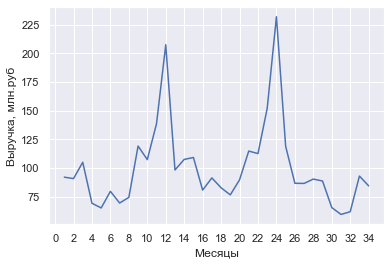

In [24]:
data = df_big.groupby(df_big["month"])["revenue"].sum().reset_index()
plt.plot(data.index+1, data["revenue"])
plt.locator_params (axis='x', nbins= 34)
plt.xlabel("Месяцы")
plt.ylabel("Выручка, млн.руб")
plt.savefig('saved_figure.jpg')

**11.3 Какие категории имеют наибольшие продажи?**
(изобразите графически)

In [25]:
t = df_big.groupby(df_big.item_category_name)["revenue"].sum().reset_index()
t = t.rename(columns={"item_category_name": "Категория", "revenue": "Продажи"})
t.nlargest(5, "Продажи")

,Категория,Продажи
19,Игры - PS3,412.05
20,Игры - PS4,373.01
12,Игровые консоли - PS4,292.24
23,Игры - XBOX 360,259.62
30,Игры PC - Стандартные издания,257.52


**11.4 Какие магазины имеют наибольшие продажи?** (изобразите графически)

In [28]:
t = df_big.groupby(df_big.shop_name)["revenue"].sum().reset_index().nlargest(5, "revenue")
t

,shop_name,revenue
28,"Москва ТЦ ""Семеновский""",235.22
22,"Москва ТРК ""Атриум""",216.48
25,"Москва ТЦ ""МЕГА Теплый Стан"" II",159.75
39,"СПб ТК ""Невский Центр""",151.92
51,"Химки ТЦ ""Мега""",141.94


<AxesSubplot:xlabel='revenue', ylabel='shop_name'>

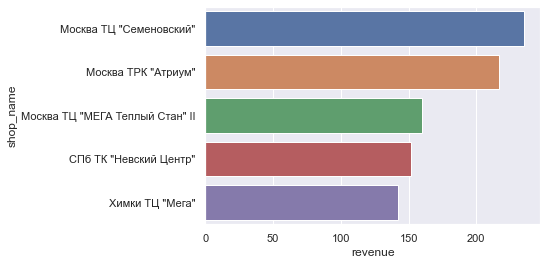

In [29]:
sns.barplot(t["revenue"], t.shop_name,)

### 12. Проверяем наличие выбросов (для этих целей можно использовать график)
Выбросы - значения не попадащие под распределение

Text(0.5, 1.0, 'Распределение прибыли сгруппированные по месяцам')

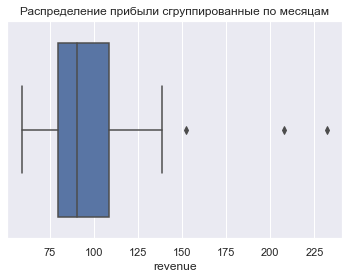

In [30]:
t = df_big.groupby(df_big["month"])["revenue"].sum().reset_index()
sns.boxplot(t["revenue"])
plt.title("Распределение прибыли сгруппированные по месяцам")

### 13. Удаляем выбросы

In [31]:
t = df_big.groupby(df_big["month"])["revenue"].sum().reset_index()
t = t[t["revenue"] < 150]
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 33
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype    
---  ------   --------------  -----    
 0   month    31 non-null     period[M]
 1   revenue  31 non-null     float64  
dtypes: float64(1), period[M](1)
memory usage: 744.0 bytes


Text(0.5, 1.0, 'Распределение выручки сгруппированные по месяцам')

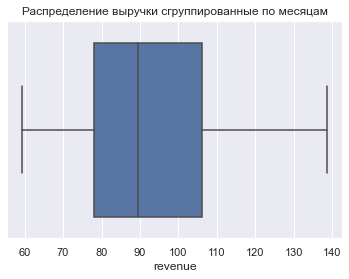

In [32]:
sns.boxplot(t["revenue"])
plt.title("Распределение выручки сгруппированные по месяцам")

### 14. Насколько изменилась цена единицы товара в сравнениее с базисной (т.е. с самой первой в периоде)

In [33]:
t

,month,revenue
0,2013-01,91.95
1,2013-02,90.67
2,2013-03,104.93
3,2013-04,69.15
4,2013-05,65.07
5,2013-06,79.55
6,2013-07,69.35
7,2013-08,74.30
8,2013-09,119.08
9,2013-10,107.24


In [34]:
((84.34/91.95)-1)*100
print("Уvменьшилась на",((84.34/91.95)-1)*100,"%")

Уvменьшилась на -8.276237085372484 %


### 15. Делаем прогноз

In [1]:
reg = LinearRegression()
x = np.array(range(1,32)).reshape(-1, 1)
result = reg.fit(x, t["revenue"])
print(result.coef_, result.intercept_)

NameError: name 'LinearRegression' is not defined

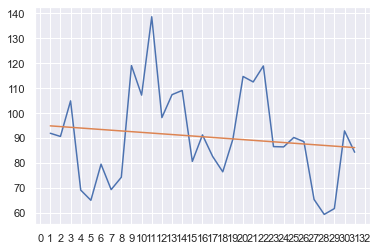

In [36]:
t["y_pred"] = x*result.coef_ + result.intercept_
plt.plot(x, t["revenue"])
plt.plot(x, t["y_pred"])
plt.locator_params (axis='x', nbins= 34)

In [37]:
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(t["revenue"], t["y_pred"]))
print('Mean Absolute Error:', metrics.mean_absolute_error(t["revenue"], t["y_pred"]))
print('R2', metrics.r2_score(t["revenue"], t["y_pred"]))

Mean Squared Error: 347.8055978273886
Mean Absolute Error: 14.735668864370426
R2 0.019040231840239175


T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


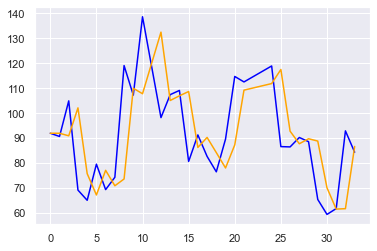

In [38]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
model = SimpleExpSmoothing(t["revenue"])
model_fit = model.fit(smoothing_level=0.8, optimized=False)

plt.plot(t["revenue"], color='blue')
plt.plot(model_fit.fittedvalues, color='orange')

T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be

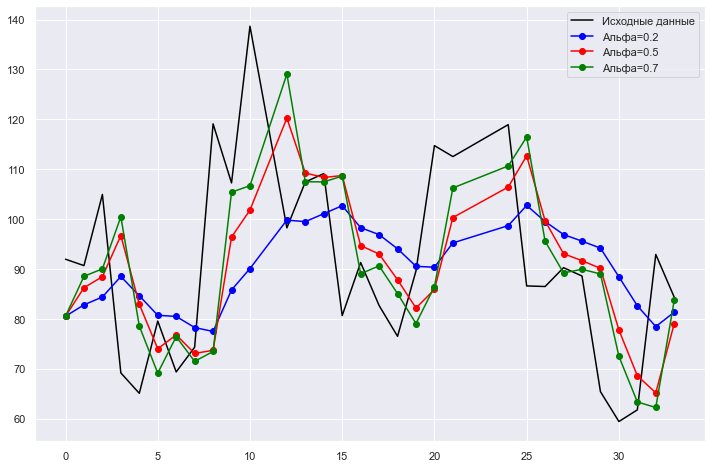

In [39]:
fit1 = SimpleExpSmoothing(t["revenue"], initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(1)
fit2 = SimpleExpSmoothing(t["revenue"], initialization_method="heuristic").fit(
    smoothing_level=0.5, optimized=False
)
fcast2 = fit2.forecast(1)

fit3 = SimpleExpSmoothing(t["revenue"], initialization_method="heuristic").fit(
    smoothing_level=0.7, optimized=False
)
fcast3 = fit3.forecast(1)

plt.figure(figsize=(12, 8))
(line1,) = plt.plot(t["revenue"], color="black")
(line2,) = plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line3,) = plt.plot(fit2.fittedvalues, marker="o", color="red")
(line4,) = plt.plot(fit3.fittedvalues, marker="o", color="green")
plt.legend([line1, line2, line3, line4], ["Исходные данные", "Альфа=0.2", "Альфа=0.5", "Альфа=0.7"])

plt.savefig('saved_figure2.jpg')

In [40]:
fcast1 = fit1.forecast(3)
fcast2 = fit2.forecast(3)
fcast3 = fit3.forecast(3)
print(fcast1)
print(fcast2)
print(fcast3)

31   81.93
32   81.93
33   81.93
dtype: float64
31   81.69
32   81.69
33   81.69
dtype: float64
31   84.15
32   84.15
33   84.15
dtype: float64


T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


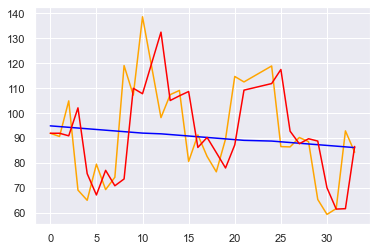

In [41]:
plt.plot(t["revenue"], color='orange')
plt.plot(t["y_pred"], color='blue')
plt.plot(model_fit.fittedvalues, color='red')


In [42]:
t

,month,revenue,y_pred
0,2013-01,91.95,94.92
1,2013-02,90.67,94.62
2,2013-03,104.93,94.33
3,2013-04,69.15,94.04
4,2013-05,65.07,93.75
5,2013-06,79.55,93.46
6,2013-07,69.35,93.17
7,2013-08,74.30,92.88
8,2013-09,119.08,92.59
9,2013-10,107.24,92.30


T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


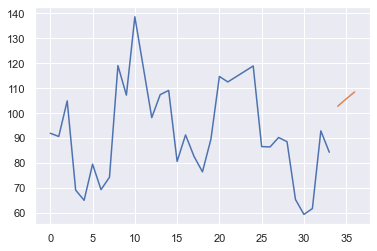

T:\AMysor\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


31   102.78
32   105.72
33   108.53
dtype: float64

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

stlf = STLForecast(t.revenue, ARIMA, model_kwargs=dict(order=(2, 1, 1)), period=12)
stlf_res = stlf.fit()

forecast = stlf_res.forecast(3)
plt.plot(t.revenue)
plt.plot([34,35,36], forecast)
plt.show()
stlf_res.forecast(3)

In [46]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                   31
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -91.086
Date:                Tue, 11 Apr 2023   AIC                            190.173
Time:                        14:18:04   BIC                            195.778
Sample:                             0   HQIC                           191.966
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8642      0.207     -4.172      0.000      -1.270      -0.458
ar.L2         -0.6893      0.134     -5.145      0.000      -0.952      -0.427
ma.L1          0.0581      0.292      0.199      0.8